In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pdb
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
from datetime import datetime
from joblib import Parallel, delayed
import copy

from data.dataloader import get_jhu_data, get_covid19india_api_data
from data.processing import get_district_time_series

from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from main.seir.losses import Loss_Calculator

In [3]:
def get_data(dataframes, state, district, use_dataframe='districts_daily', disable_tracker=False, filename=None):
    if disable_tracker:
        return pd.read_csv(filename)
    
    df_district = get_district_time_series(dataframes, state=state, district=district, use_dataframe=use_dataframe)
    return df_district

In [4]:
dataframes = get_covid19india_api_data()

/Users/mihirkulkarni/Desktop/COVID/covid-modelling/data/dataloader.py:125: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  dataframes['df_raw_data'] = pd.concat([df_raw_data_1, df_raw_data_2, df_raw_data_3], ignore_index=True)
/Users/mihirkulkarni/Desktop/COVID/covid-modelling/data/dataloader.py:140: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_districts = pd.concat([df_districts, df], ignore_index=True)


In [5]:
state = 'Maharashtra'
district = 'Pune'

In [6]:
df_district = get_data(dataframes, state, district, use_dataframe='districts_daily')

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [7]:
df_district

,state,district,date,hospitalised,total_infected,deceased,recovered
0,Maharashtra,Pune,2020-04-24,696,910,62,152
1,Maharashtra,Pune,2020-04-25,772,1030,73,185
2,Maharashtra,Pune,2020-04-26,770,1052,76,206
3,Maharashtra,Pune,2020-04-27,762,1052,80,210
4,Maharashtra,Pune,2020-04-28,873,1174,80,221
5,Maharashtra,Pune,2020-04-29,863,1192,85,244
6,Maharashtra,Pune,2020-04-30,912,1248,88,248
7,Maharashtra,Pune,2020-05-01,901,1248,99,248
8,Maharashtra,Pune,2020-05-02,952,1339,102,285
9,Maharashtra,Pune,2020-05-03,951,1396,106,339


In [8]:
def train_val_split(df_district, train_rollingmean=False, val_rollingmean=False, val_size=5, which_columns = ['hospitalised', 'total_infected', 'deceased', 'recovered']):
    print("splitting data ..")
    df_true_fitting = copy.copy(df_district)
    for column in which_columns:
        df_true_fitting[column] = df_true_fitting[column].rolling(5, center=True).mean()
    
    df_true_fitting = df_true_fitting[np.logical_not(df_true_fitting['total_infected'].isna())]
    df_true_fitting.reset_index(inplace=True, drop=True)
    
    if train_rollingmean:
        if val_size == 0:
            df_train = pd.concat([df_true_fitting, df_district.iloc[-(val_size+2):, :]], ignore_index=True)
            return df_train, None, df_true_fitting
        else:
            df_train = pd.concat([df_true_fitting.iloc[:-val_size, :], df_district.iloc[-(val_size+2):-val_size, :]], ignore_index=True)   
    else:
        if val_size == 0:
            return df_district, None, df_true_fitting  
        else:
            df_train = df_district.iloc[:-val_size, :]
        
    if val_rollingmean:
        df_val = pd.concat([df_true_fitting.iloc[-(val_size-2):, :], df_district.iloc[-2:, :]], ignore_index=True)
    else:
        df_val = df_district.iloc[-val_size:, :]
    df_val.reset_index(inplace=True, drop=True)
    return df_train, df_val, df_true_fitting

In [9]:
df_train, df_val, df_true_fitting = train_val_split(df_district, train_rollingmean=False, val_rollingmean=False, val_size=5)

splitting data ..


In [10]:
df_val.columns

Index(['state', 'district', 'date', 'hospitalised', 'total_infected',
       'deceased', 'recovered'],
      dtype='object')

In [11]:
plot_titles = {'hospitalised': 'Hospitalised',
              'total_infected': 'Confirmed Cases',
              'deceased': 'Deaths',
              'recovered': 'Recoveries'}

In [28]:
def plot_observed_and_avg(df_train, df_val, df_true_fitting, df_district, df_prediction,
                          column = 'total_infected', title = 'Confirmed Cases' , train_on_val=False):
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.plot(df_district['date'], df_district[column], label=title +' (Observed)')
        ax.plot(df_true_fitting['date'], df_true_fitting[column], label= title+' (Rolling Avg(5))')
        if train_on_val:
            ax.plot([df_train.iloc[-train_period, :]['date'], 
                     df_train.iloc[-train_period, :]['date']], [min(df_train[column]),
                     max(df_train[column])], '--r', label='Train Period Starts')
        else:
            ax.plot([df_train.iloc[-1, :]['date'], df_train.iloc[-1, :]['date']], 
                    [min(df_train[column]), max(df_val[column])], 
                    '--r', label='Train Test Boundary')
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
        ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.ylabel('No of People')
        plt.xlabel('Time')
        plt.legend()
        plt.title('Rolling Avg vs Observed ({} {})'.format(state, district))
        plt.grid()
        plt.savefig('./plots/{}_observed_{}_{}.png'.format(title, state, district))

        fig, ax = plt.subplots(figsize=(12, 12))
        ax.plot(df_train['date'], df_train[column], color='orange', label=title + ' (Rolling Avg (5))')
        ax.plot(df_prediction['date'], df_prediction[column], '-g', label=title + ' (Predicted)')
        if train_on_val:
            ax.plot([df_train.iloc[-train_period, :]['date'], 
                     df_train.iloc[-train_period, :]['date']], [min(df_train[column]),
                     max(df_train[column])], '--r', label='Train Period Starts')
        else:
            ax.plot([df_train.iloc[-1, :]['date'], df_train.iloc[-1, :]['date']], [min(df_train[column]), 
                    max(df_val[column])], '--r', label='Train Test Boundary')
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
        ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.ylabel('No of People')
        plt.xlabel('Time')
        plt.legend()
        plt.title('Total' + title + ' ({} {})'.format(state, district))
        plt.grid()
        fname = './plots/{}_predictions_{}_{}.png'.format(title, state, district)
        plt.savefig(fname)
        print("plot saved as {}".format(fname))

In [20]:
def fit_district(dataframes, state, district, train_period=10, val_period=5, train_on_val=False):
    print('fitting to data with "train_on_val" set to {} ..'.format(train_on_val))
    if not os.path.exists('./plots'):
        os.makedirs('./plots')

    df_district = get_data(dataframes, state=state, district=district, use_dataframe='districts_daily')
    df_district_raw_data = get_data(dataframes, state=state, district=district, use_dataframe='raw_data')
    if district is None:
        district = ''
        
    # Get train val split
    if train_on_val:
        df_train, df_val, df_true_fitting = train_val_split(df_district, val_rollingmean=False, val_size=0)
    else:
        df_train, df_val, df_true_fitting = train_val_split(df_district, val_rollingmean=False, val_size=val_period)

    print('train\n', df_train.tail())
    print('val\n', df_val)

    # Initialise Optimiser
    optimiser = Optimiser()
    #import pdb; pdb.set_trace()
    # Get the fixed params
    default_params = optimiser.init_default_params(df_train, init_infected=max(df_district_raw_data.iloc[0, :]['total_infected'], 1), 
                                                   start_date=df_district_raw_data.iloc[0, :]['date'])

    # Create searchspace of variable params
    variable_param_ranges = {
        'R0' : hp.uniform('R0', 1.6, 5),
        'T_inc' : hp.uniform('T_inc', 4, 5),
        'T_inf' : hp.uniform('T_inf', 3, 4),
        'T_recov_severe' : hp.uniform('T_recov_severe', 9, 20),
        'P_severe' : hp.uniform('P_severe', 0.3, 0.99),
        'P_fatal' : hp.uniform('P_fatal', 0, 0.1),
        'intervention_amount' : hp.uniform('intervention_amount', 0, 1)
    }
    
    # Perform Bayesian Optimisation
    best, trials = optimiser.bayes_opt(df_train, default_params, variable_param_ranges, method='rmse', num_evals=1500, loss_indices=[-train_period, None])

    print('best parameters\n', best)
    
    # Get Predictions dataframe
    df_prediction = optimiser.solve(best, default_params, df_train)

    
    return df_train, df_val, df_true_fitting, best, default_params, optimiser, df_prediction, df_district

In [25]:
df_train, df_val, df_true_fitting, best,\
default_params, optimiser, df_prediction, df_district =\
fit_district(dataframes, state, district, train_period=6, val_period=5, train_on_val=False)
# Create plots

    

fitting to data with "train_on_val" set to False ..
splitting data ..
train
          state district       date hospitalised total_infected deceased  \
1  Maharashtra     Pune 2020-04-25          772           1030       73   
2  Maharashtra     Pune 2020-04-26          770           1052       76   
3  Maharashtra     Pune 2020-04-27          762           1052       80   
4  Maharashtra     Pune 2020-04-28          873           1174       80   
5  Maharashtra     Pune 2020-04-29          863           1192       85   

  recovered  
1       185  
2       206  
3       210  
4       221  
5       244  
val
          state district       date hospitalised total_infected deceased  \
0  Maharashtra     Pune 2020-04-30          912           1248       88   
1  Maharashtra     Pune 2020-05-01          901           1248       99   
2  Maharashtra     Pune 2020-05-02          952           1339      102   
3  Maharashtra     Pune 2020-05-03          951           1396      106   
4  Mahar

KeyboardInterrupt: 

plot saved as ./plots/Hospitalised_predictions_Maharashtra_Pune.png
plot saved as ./plots/Confirmed Cases_predictions_Maharashtra_Pune.png
plot saved as ./plots/Deaths_predictions_Maharashtra_Pune.png
plot saved as ./plots/Recoveries_predictions_Maharashtra_Pune.png


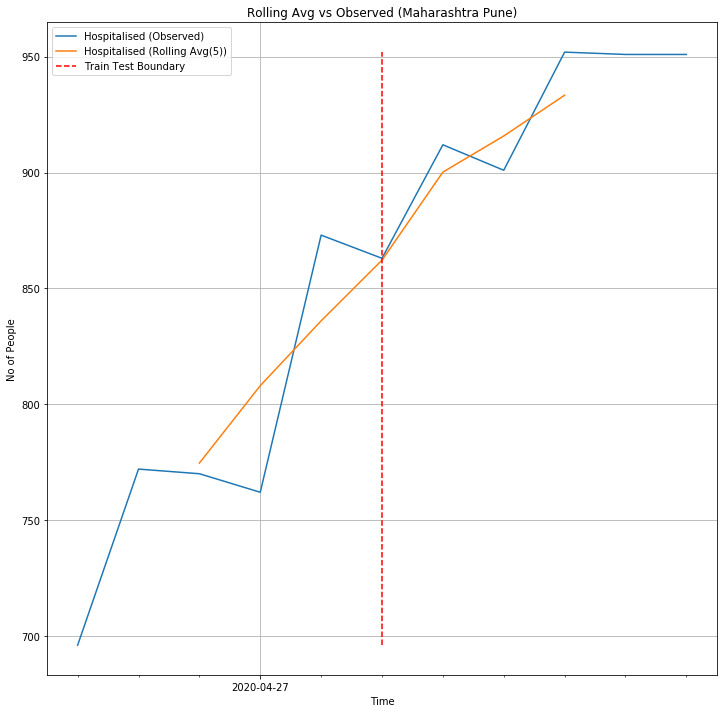

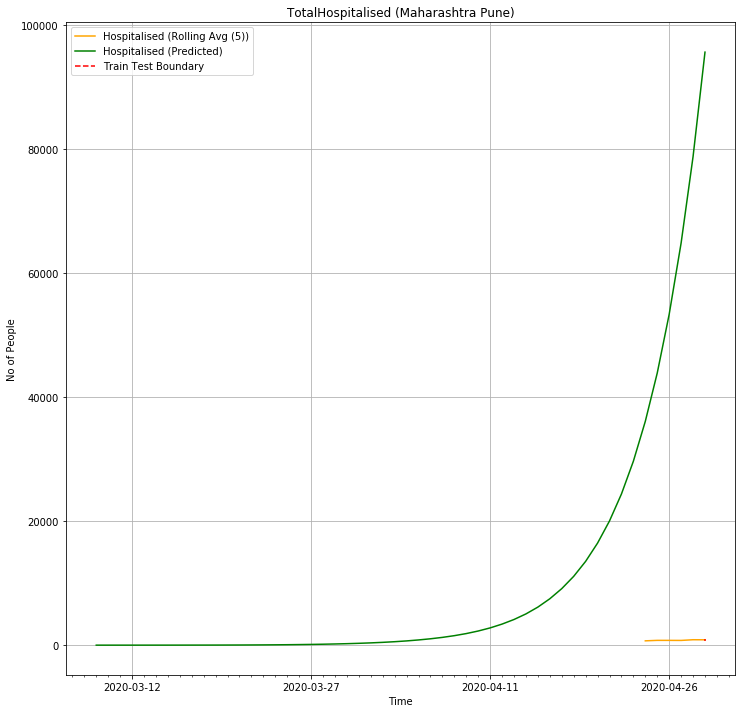

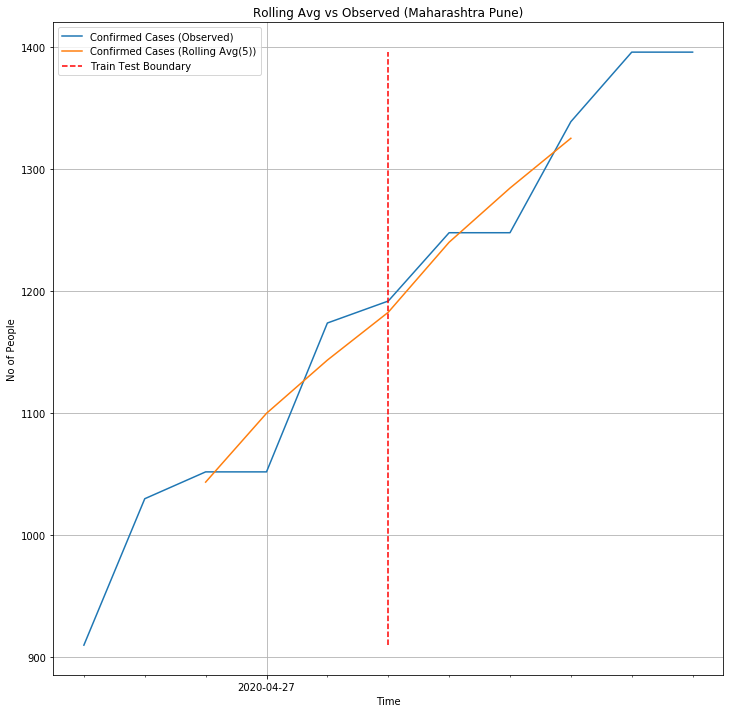

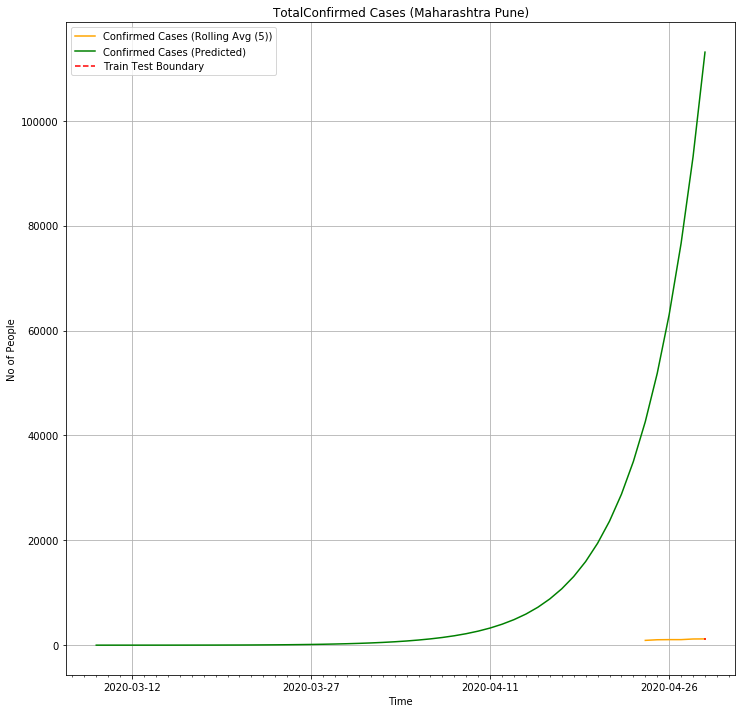

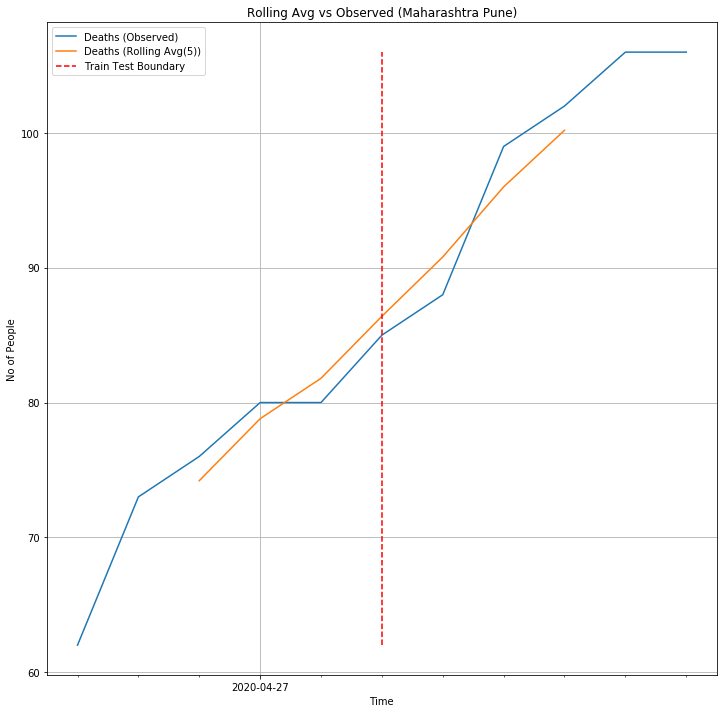

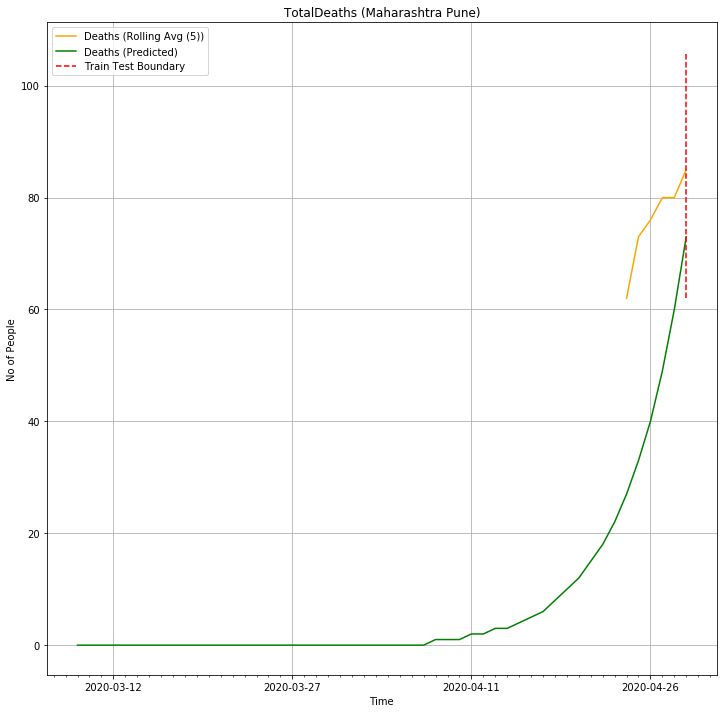

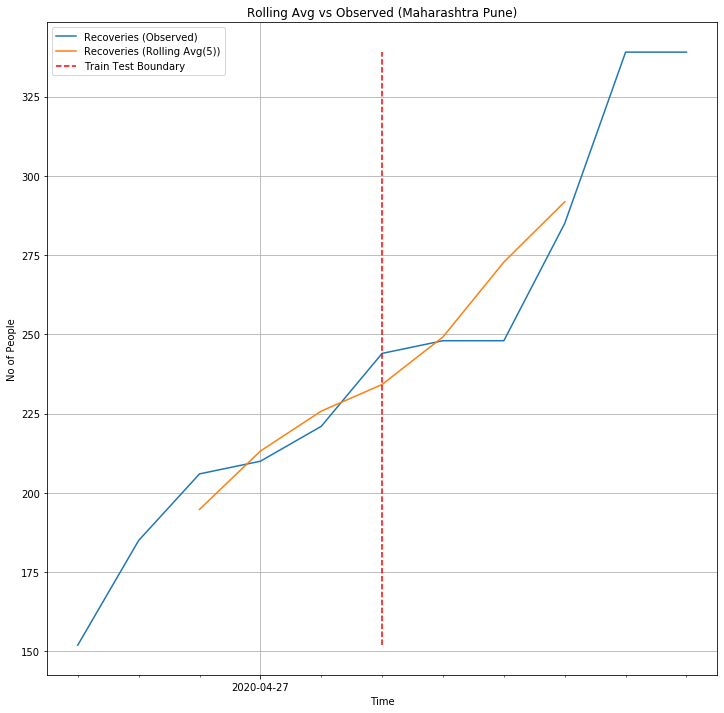

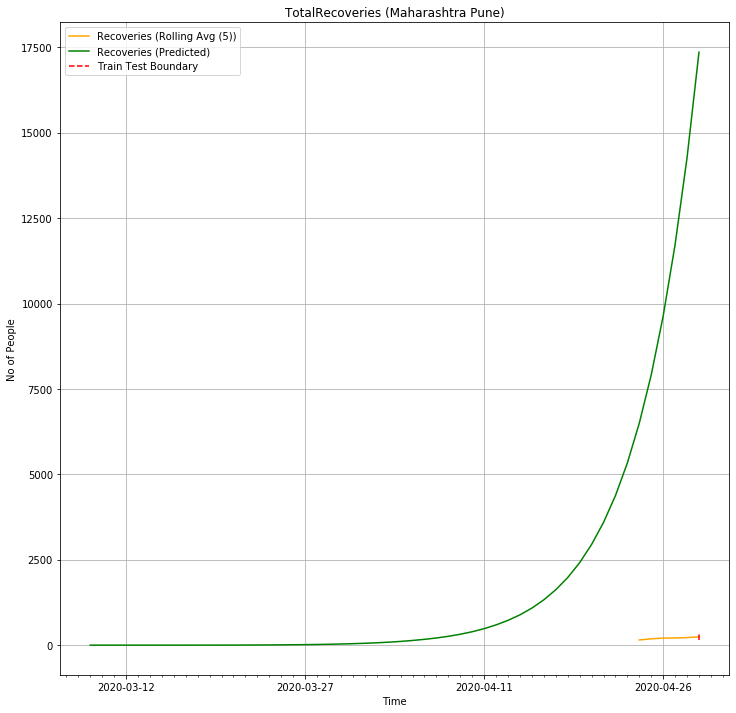

In [29]:
for key in plot_titles.keys():
        plot_observed_and_avg(df_train, df_val, df_true_fitting, df_district, df_prediction,
                          column = key, title = plot_titles[key], train_on_val=False )

In [ ]:
optimiser.init_default_params(df_train, init_infected=max(df_district_raw_data.iloc[0, :]['total_infected'], 1), 
                              start_date=df_district_raw_data.iloc[0, :]['date'])
